## Setup

In [1]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors # for player to grid assignment
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch.nn.functional as F

In [2]:
# Read In csvs
folder = '/kaggle/input/nfl-big-data-bowl-2025/'
games = pd.read_csv(folder + "games.csv")
plays = pd.read_csv(folder + "plays.csv")
players = pd.read_csv(folder + "players.csv")
player_play = pd.read_csv(folder+"player_play.csv")
week1 = pd.read_csv(folder + "tracking_week_1.csv")

In [3]:
full_tracking_data = pd.concat([week1,
                                pd.read_csv(folder + "tracking_week_2.csv"),
                                pd.read_csv(folder + "tracking_week_3.csv"),
                                pd.read_csv(folder + "tracking_week_4.csv"),
                                pd.read_csv(folder + "tracking_week_5.csv"),
                                pd.read_csv(folder + "tracking_week_6.csv"),
                                pd.read_csv(folder + "tracking_week_7.csv"),
                                pd.read_csv(folder + "tracking_week_8.csv"),
                                pd.read_csv(folder + "tracking_week_9.csv")],
                             ignore_index=True)
full_tracking_data.shape

(59327373, 18)

## Determining whether a play was a Run or Pass

In [4]:
# Group by gameId and playId and sum the hadRushAttempt column
rush_attempts = player_play.groupby(['gameId', 'playId'])['hadRushAttempt'].sum().reset_index()

# Rename the summed column to rushAttempt
rush_attempts.rename(columns={'hadRushAttempt': 'rushAttempt'}, inplace=True)

# Merge this data back into the original plays DataFrame
plays = plays.merge(rush_attempts, on=['gameId', 'playId'], how='left')

# If you want to fill missing values with 0 (in case some playId groups had no rush attempts)
plays['rushAttempt'] = plays['rushAttempt'].fillna(0).astype(int)

#print(plays['rushAttempt'])


In [5]:
# Define conditions
# it will check these in order, so 
# - if it's an rpo then it's a rpo, 
# - if there is anything in the pass result column it's a pass, (do this before runs to capture scrambles)
# - then if there's a rush attempt it's a run
# - finally, if we miss anything it's just 'unknown' (but we don't miss anything)
conditions = [
    plays['passResult'].notna(),                      # Condition for 'pass'
    plays['rushAttempt'] == 1                         # Condition for 'run'
]

# Define corresponding values
choices = ['pass', 'run']

# Use numpy.select to create the column based on conditions
plays['type'] = np.select(conditions, choices, default='unknown')
plays['type'].value_counts()

type
pass    9736
run     6388
Name: count, dtype: int64

In [6]:
## Look at type of play by formation
plays.groupby('offenseFormation')['type'].value_counts()

offenseFormation  type
EMPTY             pass    1295
                  run       47
I_FORM            run      736
                  pass     299
JUMBO             run      104
                  pass      21
PISTOL            run      415
                  pass     226
SHOTGUN           pass    6553
                  run     2238
SINGLEBACK        run     2609
                  pass    1306
WILDCAT           run       74
                  pass      13
Name: count, dtype: int64

## Predicting Type of play (run or pass)

In [7]:
def get_grids_and_labels_type(games, plays, full_tracking_data, square_length_x = 1, square_length_y = 1):
    '''
    This function is an optimized combination of get_play_locations and get_binary_matrix designed to run on the full dataset at once
    '''
    grids = []
    other_x = []
    labels = []
    ids = []
    
    # Filter down to only what we need
    temp_tracking = full_tracking_data[((full_tracking_data['displayName'] == 'football') & (full_tracking_data['frameId'] == 1)) | ((full_tracking_data['event'] == 'ball_snap') & (full_tracking_data['displayName']!='football'))]

    # Group the dataframes for faster lookup
    games_grouped = games.groupby('gameId')
    plays_grouped = plays.groupby(['gameId','playId'])
    temp_tracking_grouped = temp_tracking.groupby(['gameId','playId'])

    ## Precompute some other stuff
    
    
    x_range = np.arange(-10, 1, square_length_x)  # Horizontal range of the field
    y_range = np.arange(-33, 34, square_length_y)  # Vertical range of the field
    
    # Generate grid centers using np.meshgrid for more efficient generation
    x_centers, y_centers = np.meshgrid(x_range + square_length_x / 2, y_range + square_length_y / 2)
    grid_centers = np.column_stack([x_centers.ravel(), y_centers.ravel()])  # Flatten the arrays
    
    # Use NearestNeighbors for faster square assignment
    tree = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(grid_centers)
    
    # Calculate binary matrix dimensions
    num_rows = int(np.ceil((y_range[-1] - y_range[0]) / square_length_y))
    num_cols = int(np.ceil((x_range[-1] - x_range[0]) / square_length_x))

    # Map grid centers to binary matrix
    mapping = {}
    for i, (x, y) in enumerate(grid_centers):
        row = int((y_range[-1] - y) // square_length_y)
        col = int((x - x_range[0]) // square_length_x)
        mapping[i] = (row,col)

    man_zone_mapping = plays['pff_manZone'].fillna('None').value_counts().to_dict()
    for i,v in enumerate(man_zone_mapping.keys()):
        man_zone_mapping[v] = i
    
    pass_coverage_mapping = plays['pff_passCoverage'].fillna('None').value_counts().to_dict()
    for i,v in enumerate(pass_coverage_mapping.keys()):
        pass_coverage_mapping[v] = i
    for key,grouped in tqdm(temp_tracking_grouped):
        if len(grouped) == 1: # this only happens if the ball wasn't snapped
            continue 
            
        play_information = plays_grouped.get_group(key)
        if play_information['qbSpike'].values[0]==1 or play_information['qbKneel'].values[0]==1: # don't deal with spikes and kneels
            continue
        
        posteam = play_information['possessionTeam'].values[0]
        offense = grouped[grouped['club'].isin([posteam,'football'])].copy()
        yardline = play_information['absoluteYardlineNumber'].values[0] # Distance from end zone for possession team

        max_x, max_y = 120, 53.3
        if offense['playDirection'].values[0] == 'left':
            # rotate
            offense['x'] = max_x - offense['x']
            offense['y'] = max_y - offense['y']

            yardline = max_x - yardline
    
        
        ball = offense[offense['displayName']=='football']
        offense = offense[offense['displayName']!='football']
        
        offense[['x', 'y']] -= [ball['x'].values[0], ball['y'].values[0]]
        offense = offense[['x', 'y']]
        player_coords = offense.values
    
        if np.any(player_coords[:, 0] >= 0):
            # Calculate the shift: how much to subtract to make all x values negative
            shift_amount = np.max(player_coords[:, 0]) + .01 # + 0.01 to make sure everything is strictly negative
            player_coords[:, 0] -= shift_amount
        
        distances, indices = tree.kneighbors(player_coords)
    
        offense['square_idx'] = indices.ravel()
        offense['assigned_square_x'], offense['assigned_square_y'] = grid_centers[indices.ravel()].T
    
    
        binary_matrix = np.zeros((num_rows, num_cols), dtype=int)
    
        # Map grid centers to binary matrix using precomputed assignments:
        binary_matrix = np.zeros((num_rows, num_cols), dtype=int)
        player_square_indices = offense['square_idx'].values    
        for i in player_square_indices:
            row,col = mapping[i]
            binary_matrix[row, col] = 1


        ## The other information we will provide the model to predict the type of play
        
        # Score Differential
        hometeam = games_grouped.get_group(key[0])['homeTeamAbbr'].values[0]
        posteam_is_hometeam = posteam == hometeam
        # score differential is the posteam's score - defteam's score
        #print(play_information['preSnapHomeScore'].values[0], play_information['preSnapVisitorScore'].values[0])
        score_differential = (play_information['preSnapHomeScore'].values[0] - play_information['preSnapVisitorScore'].values[0] 
                              if posteam_is_hometeam else
                              play_information['preSnapVisitorScore'].values[0] - play_information['preSnapHomeScore'].values[0]) 
        
        # Yardline
        # Calculated Earlier

        # Yards to go
        ydstogo = play_information['yardsToGo'].values[0]

        # Down
        down = play_information['down'].values[0]

        # Quarter
        quarter = play_information['quarter'].values[0]

        # Seconds on Game Clock
        clock = play_information['gameClock'].values[0]
        split = clock.split(':')
        secs_left = int(split[0]) * 60 + int(split[1])

        def_formation = play_information['pff_passCoverage'].fillna('None').values[0]
        pass_coverage = np.zeros(len(pass_coverage_mapping))
        pass_coverage[pass_coverage_mapping[def_formation]] = 1

        man_zone_play = play_information['pff_manZone'].fillna('None').values[0]
        man_zone = np.zeros(len(man_zone_mapping))
        man_zone[man_zone_mapping[man_zone_play]] = 1

        other_information = [score_differential,yardline,ydstogo,down,quarter,secs_left]
        other_information.extend(pass_coverage)
        other_information.extend(man_zone)

        other_information = torch.tensor(np.array(other_information),dtype=torch.float32)

        other_x.append(other_information)
        grids.append(torch.tensor(binary_matrix, dtype=torch.float32))
        labels.append(play_information['type'].values[0])
        ids.append([play_information['gameId'].values[0],play_information['playId'].values[0]])

    return grids,labels,other_x, ids

In [8]:
def precompute_data_type(games,plays, full_tracking_data, save_path="precomputed_data_type.pt"):
    """
    Precomputes binary matrices and labels, saves them to a file, and returns them as tensors.
    
    Args:
        plays (pd.DataFrame): The plays dataframe containing play information.
        full_tracking_data (pd.DataFrame): The full tracking data containing player locations.
        save_path (str): Path to save the precomputed data.        
    Returns:
        Tuple: (grids, encoded_labels, le, grid_shape)
    """
    
    grids,labels,other_x, ids = get_grids_and_labels_type(games,plays,full_tracking_data)

    # Encode labels
    le = LabelEncoder()
    encoded_labels = le.fit_transform(labels)
    encoded_labels = torch.tensor(encoded_labels, dtype=torch.long)  # Convert to tensor

    # Save data
    torch.save((grids, encoded_labels,other_x, le, grids[0].shape, ids), save_path)
    return grids, encoded_labels,other_x, le, grids[0].shape, ids

In [9]:
def setup_data_from_precomputed_type(save_path="precomputed_data_type.pt",split_type='random', test_split=0.3, batch_size=32,train_flip=False,test_flip=False):
    """
    Loads precomputed data and splits it into train, validation, and test sets.
    """
    # Load precomputed data
    grids, labels, other_x, le, shape, ids = torch.load(save_path, weights_only=False)  # Ensure correct unpacking

    # Split data
    if split_type=='random':
        X_train, X_temp, y_train, y_temp, other_x_train, other_x_temp, id_train, id_temp = train_test_split(
            grids, labels, other_x, ids, test_size=test_split, random_state=42
        )
        X_val, X_test, y_val, y_test, other_x_val, other_x_test, id_val, id_test = train_test_split(
            X_temp, y_temp, other_x_temp, id_temp, test_size=0.5, random_state=42
        )
    elif split_type == 'week':
        train_mask = pd.DataFrame(ids)[0].isin(games[games['week'].isin([1,2,3,4,5])]['gameId'])
        X_train = [grid for grid, include in zip(grids, train_mask) if include]
        y_train = torch.tensor([label for label, include in zip(labels, train_mask) if include])
        other_x_train = [other_x_i for other_x_i, include in zip(other_x, train_mask) if include]
        id_train = [id for id, include in zip(ids, train_mask) if include]
        
        
        val_mask = pd.DataFrame(ids)[0].isin(games[games['week'].isin([6,7])]['gameId'])
        X_val = [grid for grid, include in zip(grids, val_mask) if include]
        y_val = torch.tensor([label for label, include in zip(labels, val_mask) if include])
        other_x_val = [other_x_i for other_x_i, include in zip(other_x, val_mask) if include]
        id_val = [id for id, include in zip(ids, val_mask) if include]
        
        test_mask = pd.DataFrame(ids)[0].isin(games[games['week'].isin([8,9])]['gameId'])
        X_test = [grid for grid, include in zip(grids, test_mask) if include]
        y_test = torch.tensor([label for label, include in zip(labels, test_mask) if include])
        other_x_test = [other_x_i for other_x_i, include in zip(other_x, test_mask) if include]
        id_test = [id for id, include in zip(ids, test_mask) if include]
    elif split_type == 'game':
        # Step 1: Get unique IDs
        unique_ids = pd.DataFrame(ids)[0].drop_duplicates()
        
        # Step 2: Randomly shuffle the unique IDs
        shuffled_ids = unique_ids.sample(frac=1, random_state=42).reset_index(drop=True)
        
        # Step 3: Split the shuffled list into 80%, 5%, and 15%
        n = len(shuffled_ids)
        train_ids = shuffled_ids[:int(1-test_split * n)]  # 80%
        val_ids = shuffled_ids[int(1-test_split * n):int(1-test_split/2 * n)]  # 5%
        test_ids = shuffled_ids[int(1-test_split/2 * n):]  # 15%
        
        
        train_mask = [id[0] in set(train_ids) for id in ids]
        X_train = [grid for grid, include in zip(grids, train_mask) if include]
        y_train = torch.tensor([label for label, include in zip(labels, train_mask) if include])
        other_x_train = [other_x_i for other_x_i, include in zip(other_x, train_mask) if include]
        id_train = [id for id, include in zip(ids, train_mask) if include]
        
        val_mask = [id[0] in set(val_ids) for id in ids]
        X_val = [grid for grid, include in zip(grids, val_mask) if include]
        y_val = torch.tensor([label for label, include in zip(labels, val_mask) if include])
        other_x_val = [other_x_i for other_x_i, include in zip(other_x, val_mask) if include]
        id_val = [id for id, include in zip(ids, val_mask) if include]
        
        test_mask = [id[0] in set(test_ids) for id in ids]
        X_test = [grid for grid, include in zip(grids, test_mask) if include]
        y_test = torch.tensor([label for label, include in zip(labels, test_mask) if include])
        other_x_test = [other_x_i for other_x_i, include in zip(other_x, test_mask) if include]
        id_test = [id for id, include in zip(ids, test_mask) if include]
    else:
        print("Invalid Split Type")
        return

    # Create datasets and loaders
    train_dataset = PrecomputedOffenseDataset_type(X_train, y_train, other_x_train, id_train,train_flip)
    val_dataset = PrecomputedOffenseDataset_type(X_val, y_val, other_x_val, id_val,test_flip)
    test_dataset = PrecomputedOffenseDataset_type(X_test, y_test, other_x_test, id_test,test_flip)

    print(f"Training Dataset Size: {len(train_dataset)} | Validation Dataset Size: {len(val_dataset)} | Testing Dataset Size: {len(test_dataset)}")

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader, len(le.classes_), le, shape


class PrecomputedOffenseDataset_type(Dataset):
    """
    Dataset class for precomputed grids, labels, and other_x.
    """
    def __init__(self, tensor_grids, tensor_labels, tensor_other_x, ids,flip=False):
        self.grids = tensor_grids
        self.labels = tensor_labels
        self.other_x = tensor_other_x
        self.ids = ids

        if flip:
            flipped_grids = [torch.flip(grid, dims=[0]) for grid in tensor_grids]  # Flip along height (vertical axis)
            self.grids.extend(flipped_grids)
            self.labels = torch.cat([self.labels, self.labels], dim=0)  # Duplicate labels for flipped grids
            self.other_x.extend(self.other_x)
            self.ids.extend(self.ids)


    def __len__(self):
        return len(self.grids)

    def __getitem__(self, idx):
        return self.grids[idx], self.labels[idx], self.other_x[idx], self.ids[idx]


In [10]:
grids,labels,other_x, le, shape, ids = precompute_data_type(games,plays,full_tracking_data)

train_loader, val_loader, test_loader, num_classes, le, shape = setup_data_from_precomputed_type(batch_size=32)

100%|██████████| 16124/16124 [01:56<00:00, 138.30it/s]


Training Dataset Size: 11111 | Validation Dataset Size: 2381 | Testing Dataset Size: 2382


In [11]:
# Training function
def train_model_type(train_loader, val_loader, num_classes, shape, epochs=100, print_every=10, patience=5, model_path="best_model_type.pth", plot_losses=False, plot_accuracies=False):
    """
    Trains a CNN model and saves the best-performing model to disk.
    
    Args:
        train_loader (DataLoader): Training data loader
        val_loader (DataLoader): Validation data loader
        num_classes (int): Number of classes for classification
        shape (tuple): Input shape of the grid (e.g., (64, 64))
        epochs (int): Number of epochs to train the model
        print_every (int): Frequency to print loss/accuracy statistics
        patience (int): Number of epochs to wait for improvement before early stopping
        model_path (str): Path to save the best model
        plot_losses (bool): Whether to plot training and validation losses
        plot_accuracies (bool): Whether to plot training and validation accuracies
    
    Returns:
        str: Path to the saved best model
    """
    # Initialize the model, criterion, and optimizer
    model = OffenseFormationCNN_type(num_classes, shape[0], shape[1])
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    best_val_loss = float('inf')
    best_epoch = 0
    early_stop_counter = 0

    # Initialize lists to store loss and accuracy for plotting
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        for grid, labels, other_x, ids in train_loader:
            grid = grid.unsqueeze(1)  # Add channel dimension (for grayscale images)
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(grid, other_x)
            
            # Calculate loss
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)  # Get the index of the max log-probability
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        # Validation phase
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():  # No gradients needed for validation
            for inputs, labels, other_x, ids in val_loader:
                inputs = inputs.unsqueeze(1)  # Add channel dimension (for grayscale images)
                
                # Forward pass
                outputs = model(inputs,other_x)
                
                # Calculate loss
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                # Calculate accuracy
                _, predicted = torch.max(outputs, 1)  # Get the index of the max log-probability
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
    
        # Calculate training and validation accuracy
        train_accuracy = 100 * train_correct / train_total
        val_accuracy = 100 * val_correct / val_total
        
        # Track losses and accuracies for plotting
        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        
        # Print the statistics every `print_every` epochs
        if (epoch + 1) % print_every == 0:
            print(f"Epoch {epoch + 1}/{epochs} | "
                  f"Train Loss: {train_loss / len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}% | "
                  f"Val Loss: {val_loss / len(val_loader):.4f}, Val Accuracy: {val_accuracy:.2f}%")
        elif epoch == 0:
            print(f"Epoch {epoch}/{epochs} | "
                  f"Train Loss: {train_loss / len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}% | "
                  f"Val Loss: {val_loss / len(val_loader):.4f}, Val Accuracy: {val_accuracy:.2f}%")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch + 1  # Save the epoch (1-based index) of the best model
            torch.save(model.state_dict(), model_path)
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print(f"Early stopping triggered on epoch {epoch + 1}. Best epoch was {best_epoch}.")
                break

    # Plot the losses if specified
    if plot_losses:
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
        plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
        plt.axvline(x=best_epoch, color='r', linestyle='--', label="Best Model")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training and Validation Loss")
        plt.legend()
        plt.grid(True)
        plt.show()

    # Plot the accuracies if specified
    if plot_accuracies:
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label="Train Accuracy")
        plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label="Validation Accuracy")
        plt.axvline(x=best_epoch, color='r', linestyle='--', label="Best Model")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy (%)")
        plt.title("Training and Validation Accuracy")
        plt.legend()
        plt.grid(True)
        plt.show()

    return model_path

# Test function
def test_model_type(test_loader, model_path, num_classes, shape):
    """
    Evaluates the trained model on the test set.
    """
    model = OffenseFormationCNN_type(num_classes,shape[0],shape[1])
    model.load_state_dict(torch.load(model_path,weights_only=True))
    model.eval()

    test_accuracy = 0
    with torch.no_grad():
        for inputs, labels, other_x, ids in test_loader:
            inputs = inputs.unsqueeze(1)  # Add channel dimension
            outputs = model(inputs,other_x)
            predictions = outputs.argmax(dim=1)
            test_accuracy += (predictions == labels).sum().item()

    test_accuracy /= len(test_loader.dataset)
    print(f"Test Accuracy: {100*test_accuracy:.2f}")
    return test_accuracy

# CNN Model Definition
class OffenseFormationCNN_type(nn.Module):
    def __init__(self, num_classes, input_height, input_width, other_x_size=29):
        """
        CNN model that processes grid data with convolutional layers and 
        incorporates other_x as input to the fully connected layers.

        Args:
            num_classes (int): Number of output classes.
            input_height (int): Height of the input grid.
            input_width (int): Width of the input grid.
            other_x_size (int): Size of the additional tensor other_x.
        """
        super(OffenseFormationCNN_type, self).__init__()
        
        # Define parameters based on input grid size
        self.input_height = input_height
        self.input_width = input_width
        self.other_x_size = other_x_size
        
        # Convolutional layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),  # Input: 1 channel, Output: 16 channels
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Compute the output size after convolution and pooling
        self._compute_output_size()

        # Fully connected layers with residual connections
        self.fc1 = nn.Sequential(
            nn.Linear(self.flattened_size + self.other_x_size, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.BatchNorm1d(128)
        )

        self.fc2 = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.BatchNorm1d(128)
        )

        self.fc3 = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.BatchNorm1d(128)
        )

        self.output_layer = nn.Linear(128, num_classes)

    def _compute_output_size(self):
        # Create a dummy input to calculate the output size after conv layers
        dummy_input = torch.randn(1, 1, self.input_height, self.input_width)
        
        # Pass through conv layers to get the output size
        with torch.no_grad():
            conv_output = self.conv_layers(dummy_input)
        
        # Get the size of the output after convolution and pooling
        self.flattened_size = conv_output.numel()

    def forward(self, grid, other_x):
        """
        Forward pass for the CNN model.

        Args:
            grid (torch.Tensor): Input grid tensor of shape (batch_size, 1, height, width).
            other_x (torch.Tensor): Input other_x tensor of shape (batch_size, other_x_size).

        Returns:
            torch.Tensor: Model output logits.
        """
        # Process grid through convolutional layers
        grid_features = self.conv_layers(grid)
        grid_features = grid_features.view(grid_features.size(0), -1)  # Flatten
        
        # Concatenate with other_x
        combined_features = torch.cat((grid_features, other_x), dim=1)
        
        # Pass through fully connected layers with residual connections
        x1 = self.fc1(combined_features)
        x2 = self.fc2(x1) + x1  # Residual connection after fc2
        x3 = self.fc3(x2) + x2  # Residual connection after fc3
        
        # Final output layer
        output = self.output_layer(x3)
        return output

In [12]:
# # Step 1: Setup data
# train_loader, val_loader, test_loader, num_classes, le, shape = setup_data_from_precomputed_type(batch_size = 256,train_flip=True)

# # Step 2: Train model
# model_path = train_model_type(train_loader, val_loader, num_classes, shape,
#                          epochs = 100, print_every = 2, patience = 20, 
#                          plot_losses=False, plot_accuracies=True)

# # Step 3: Test model
# test_accuracy = test_model_type(test_loader, model_path, num_classes,shape)

Training Dataset Size: 18632 | Validation Dataset Size: 3303 | Testing Dataset Size: 3255
Epoch 0/100 | Train Loss: 0.6846, Train Accuracy: 58.87% | Val Loss: 0.5554, Val Accuracy: 71.78%
Epoch 2/100 | Train Loss: 0.5409, Train Accuracy: 72.29% | Val Loss: 0.4809, Val Accuracy: 77.17%
Epoch 4/100 | Train Loss: 0.4971, Train Accuracy: 75.05% | Val Loss: 0.4861, Val Accuracy: 77.02%
Epoch 6/100 | Train Loss: 0.4934, Train Accuracy: 75.43% | Val Loss: 0.4775, Val Accuracy: 77.11%
Epoch 8/100 | Train Loss: 0.4836, Train Accuracy: 75.64% | Val Loss: 0.4685, Val Accuracy: 77.90%
Epoch 10/100 | Train Loss: 0.4770, Train Accuracy: 76.26% | Val Loss: 0.5014, Val Accuracy: 76.78%
Epoch 12/100 | Train Loss: 0.4756, Train Accuracy: 75.89% | Val Loss: 0.4808, Val Accuracy: 78.11%
Epoch 14/100 | Train Loss: 0.4677, Train Accuracy: 76.64% | Val Loss: 0.5011, Val Accuracy: 74.39%
Epoch 16/100 | Train Loss: 0.4605, Train Accuracy: 77.11% | Val Loss: 0.4763, Val Accuracy: 77.17%
Epoch 18/100 | Train Los

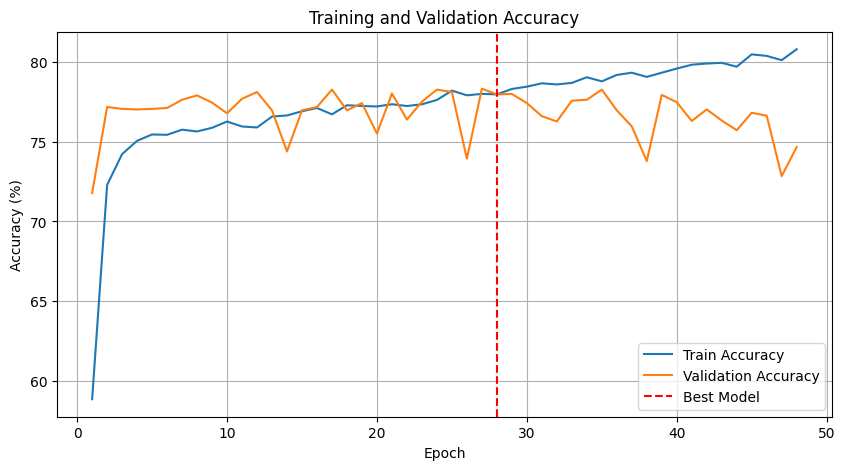

Test Accuracy: 76.71


In [13]:
# Step 1: Setup data
train_loader, val_loader, test_loader, num_classes, le, shape = setup_data_from_precomputed_type(batch_size = 256,split_type='week',train_flip=True)

# Step 2: Train model
model_path = train_model_type(train_loader, val_loader, num_classes, shape,
                         epochs = 100, print_every = 2, patience = 20, 
                         plot_losses=False, plot_accuracies=True)

# Step 3: Test model
test_accuracy = test_model_type(test_loader, model_path, num_classes,shape)

In [14]:
# # Step 1: Setup data
# train_loader, val_loader, test_loader, num_classes, le, shape = setup_data_from_precomputed_type(batch_size = 256,split_type='game',train_flip=True)

# # Step 2: Train model
# model_path = train_model_type(train_loader, val_loader, num_classes, shape,
#                          epochs = 100, print_every = 2, patience = 20, 
#                          plot_losses=False, plot_accuracies=True)

# # Step 3: Test model
# test_accuracy = test_model_type(test_loader, model_path, num_classes,shape)

## Looking at the predictions

In [15]:
def get_all_predictions(model_path,train_loader,val_loader,test_loader,le):
    model = OffenseFormationCNN_type(num_classes,shape[0],shape[1])
    model.load_state_dict(torch.load(model_path,weights_only=True))
    model.eval()
    
    
    with torch.no_grad():
        game_ids = []
        play_ids = []
        all_predictions = []
        truths = []
        type = []
    
        for inputs, labels, other_x, ids in train_loader:
            inputs = inputs.unsqueeze(1)  # Add channel dimension
            outputs = model(inputs,other_x)
            predictions = outputs.argmax(dim=1)
            
            game_ids.extend(ids[0].tolist())
            play_ids.extend(ids[1].tolist())
            all_predictions.extend(le.inverse_transform([pred.item() for pred in predictions]).tolist())
            truths.extend(le.inverse_transform(labels.tolist()).tolist())
            type.extend(['train'] * len(predictions))
    
        for inputs, labels, other_x, ids in val_loader:
            inputs = inputs.unsqueeze(1)  # Add channel dimension
            outputs = model(inputs,other_x)
            predictions = outputs.argmax(dim=1)
            
            game_ids.extend(ids[0].tolist())
            play_ids.extend(ids[1].tolist())
            all_predictions.extend(le.inverse_transform([pred.item() for pred in predictions]).tolist())
            truths.extend(le.inverse_transform(labels.tolist()).tolist())
            type.extend(['val'] * len(predictions))
        
        for inputs, labels, other_x, ids in test_loader:
            inputs = inputs.unsqueeze(1)  # Add channel dimension
            outputs = model(inputs,other_x)
            predictions = outputs.argmax(dim=1)
            
            game_ids.extend(ids[0].tolist())
            play_ids.extend(ids[1].tolist())
            all_predictions.extend(le.inverse_transform([pred.item() for pred in predictions]).tolist())
            truths.extend(le.inverse_transform(labels.tolist()).tolist())
            type.extend(['test'] * len(predictions))
            
    
    results = pd.DataFrame({'gameId':game_ids,
                            'playId':play_ids,
                            'prediction':all_predictions,
                            'truth':truths,
                            'split':type})
    return results

In [16]:
predictions = get_all_predictions(model_path,train_loader,val_loader,test_loader,le)
predictions['correct'] = (predictions['prediction'] == predictions['truth']).astype(int)
predictions = predictions.merge(plays,on=['gameId','playId'],how='left')
predictions

,gameId,playId,prediction,truth,split,correct,playDescription,quarter,down,yardsToGo,...,visitorTeamWinProbilityAdded,expectedPointsAdded,isDropback,pff_runConceptPrimary,pff_runConceptSecondary,pff_runPassOption,pff_passCoverage,pff_manZone,rushAttempt,type
0,2022091803,2898,pass,pass,train,1,(9:17) (Shotgun) T.Lawrence pass short right t...,4,3,6,...,0.000204,-1.075598,True,NaN,NaN,0,Cover-3,Zone,0,pass
1,2022100910,1714,pass,pass,train,1,(1:53) (Shotgun) J.Garoppolo pass short right ...,2,3,10,...,-0.008970,-0.758814,True,NaN,NaN,0,Cover-2,Zone,0,pass
2,2022100910,1225,pass,pass,train,1,(9:27) (Shotgun) B.Mayfield pass short left to...,2,1,20,...,-0.008256,0.704407,True,NaN,NaN,0,Cover-1,Man,0,pass
3,2022100903,1018,run,run,train,1,(13:50) R.Burkhead left end to JAX 32 for no g...,2,2,4,...,-0.019796,-0.752287,False,OUTSIDE ZONE,LEAD,0,Cover-1,Man,1,run
4,2022092508,3941,pass,pass,train,1,(3:55) (Shotgun) C.Wentz pass short left to J....,4,1,10,...,-0.000027,1.503249,True,NaN,NaN,0,Cover-2,Zone,0,pass
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25185,2022110700,3658,run,run,test,1,(3:14) (Shotgun) K.Drake left tackle to BLT 46...,4,3,1,...,0.001560,0.232945,False,OUTSIDE ZONE,NaN,0,Cover-0,Man,1,run
25186,2022110700,3686,run,run,test,1,(2:31) K.Drake right guard to NO 49 for 5 yard...,4,1,10,...,0.000465,-0.156217,False,POWER,LEAD,0,Cover-0,Man,1,run
25187,2022110700,3707,run,run,test,1,(2:00) (Shotgun) K.Drake right end to NO 45 fo...,4,2,5,...,-0.000388,0.196326,False,COUNTER,LEAD;READ OPTION,0,Cover-0,Man,1,run
25188,2022110700,3740,run,run,test,1,(1:15) (Shotgun) K.Drake left end to BLT 48 fo...,4,3,1,...,-0.000345,-0.983689,False,PULL LEAD,LEAD;PITCH,0,Cover-0,Man,1,run


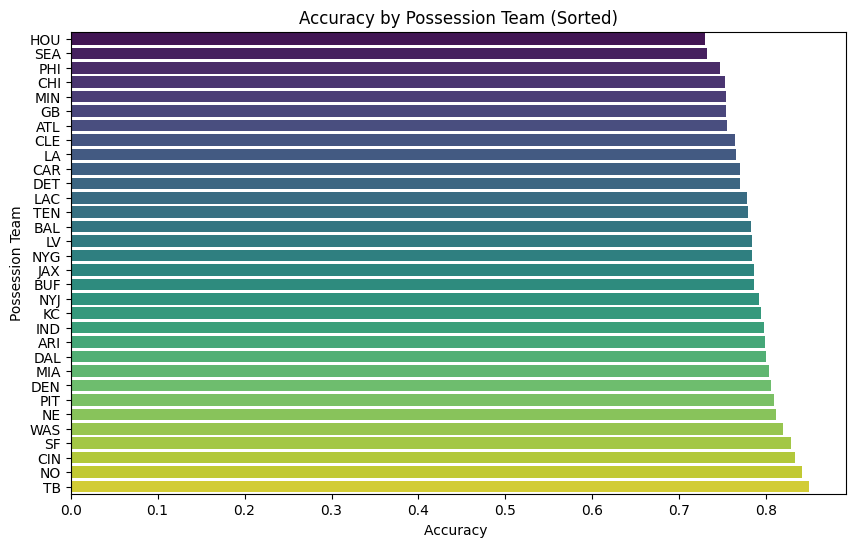

In [17]:
# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=predictions.groupby('possessionTeam')['correct'].mean().sort_values().reset_index(), y='possessionTeam', x='correct', palette='viridis')
plt.title("Accuracy by Possession Team (Sorted)")
plt.xlabel("Accuracy ")
plt.ylabel("Possession Team")
plt.show()

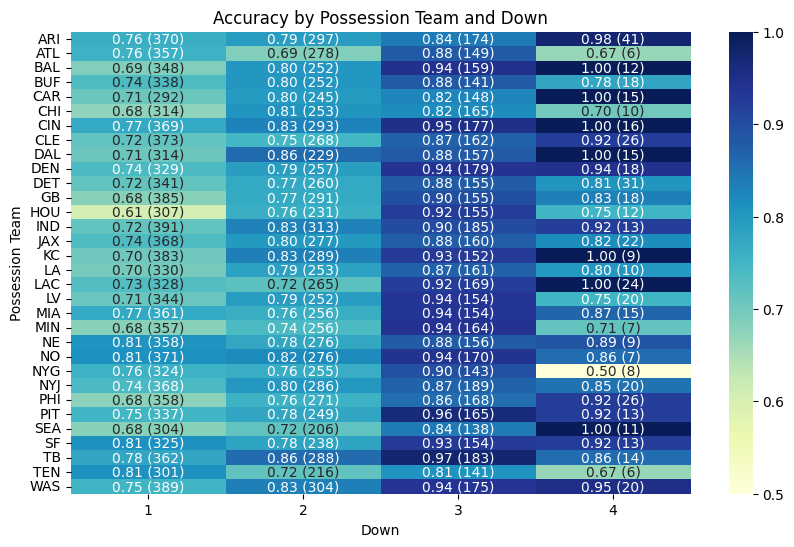

In [18]:
# Compute mean and count values
grouped = predictions.groupby(['possessionTeam', 'down'])['correct']
means = grouped.mean().unstack()
counts = grouped.count().unstack()

# Create a DataFrame for custom annotations with dtype=object
annot = means.astype(str).copy()
for i in range(means.shape[0]):
    for j in range(means.shape[1]):
        if not np.isnan(means.iloc[i, j]):  # Handle NaN values
            annot.iloc[i, j] = f"{means.iloc[i, j]:.2f} ({counts.iloc[i, j]})"
        else:
            annot.iloc[i, j] = ""  # Leave empty for NaN values

# Plot the heatmap with custom annotations
plt.figure(figsize=(10, 6))
sns.heatmap(means, annot=annot, fmt="", cmap="YlGnBu", cbar=True)
plt.title("Accuracy by Possession Team and Down")
plt.xlabel("Down")
plt.ylabel("Possession Team")
plt.show()

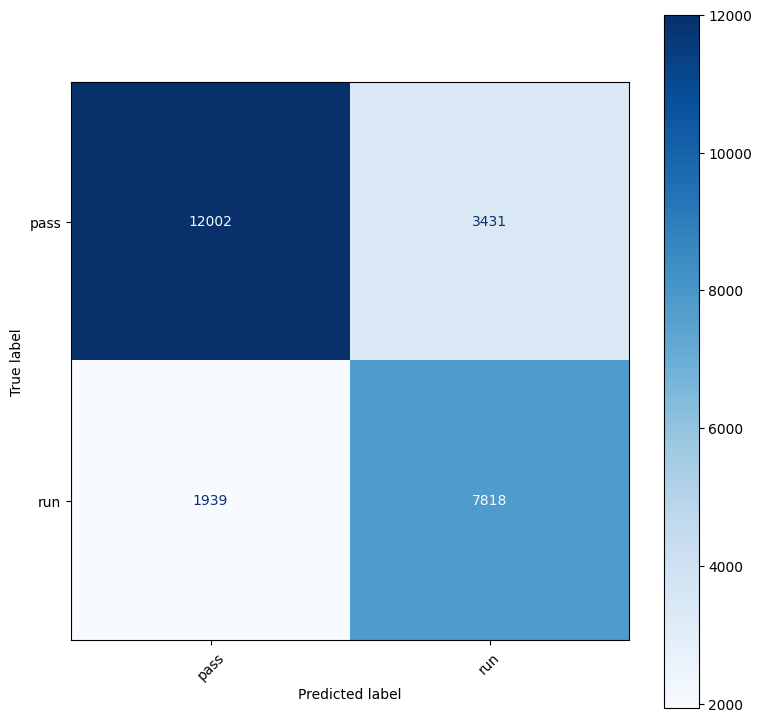

In [19]:
# Define the correct order of labels
label_order = sorted(set(predictions['truth']).union(set(predictions['prediction'])))

# Generate confusion matrix with specified label order
cm = confusion_matrix(predictions['truth'], predictions['prediction'], labels=label_order)

# Display the confusion matrix with consistent label order
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_order)
fig, ax = plt.subplots(figsize=(9,9))  # Adjust figure size as needed
cmd.plot(cmap="Blues", ax=ax, values_format='d')

# Rotate x-axis labels
plt.xticks(rotation=45)
plt.show()

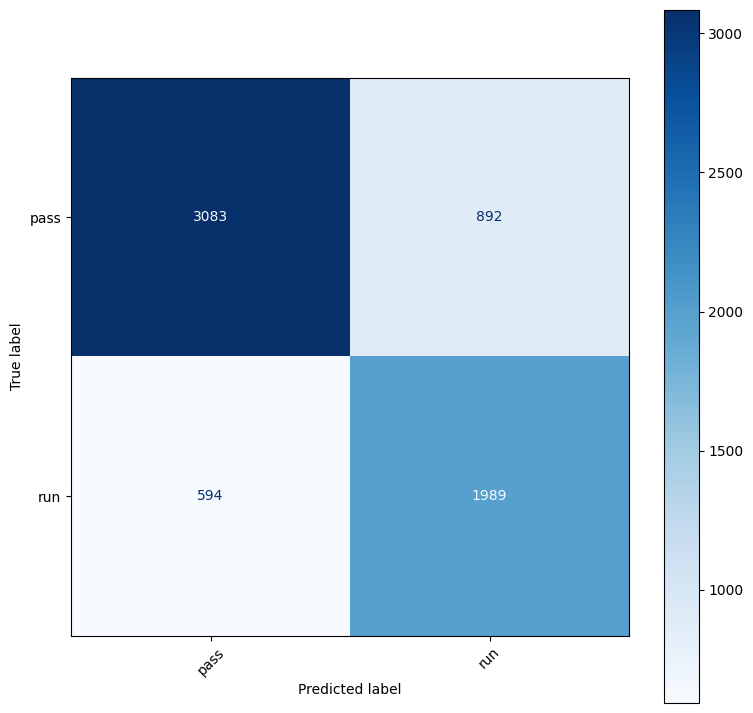

In [20]:
# Define the correct order of labels
not_train = predictions[predictions['split']!= 'train']
label_order = sorted(set(not_train['truth']).union(set(not_train['prediction'])))

# Generate confusion matrix with specified label order
cm = confusion_matrix(not_train['truth'], not_train['prediction'], labels=label_order)

# Display the confusion matrix with consistent label order
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_order)
fig, ax = plt.subplots(figsize=(9,9))  # Adjust figure size as needed
cmd.plot(cmap="Blues", ax=ax, values_format='d')

# Rotate x-axis labels
plt.xticks(rotation=45)
plt.show()

In [21]:
def get_all_predictions_probs(model_path,train_loader,val_loader,test_loader,le):
    model = OffenseFormationCNN_type(num_classes,shape[0],shape[1])
    model.load_state_dict(torch.load(model_path,weights_only=True))
    model.eval()
    
    
    with torch.no_grad():
        game_ids = []
        play_ids = []
        all_predictions = []
        truths = []
        type = []
    
        for inputs, labels, other_x, ids in train_loader:
            inputs = inputs.unsqueeze(1)  # Add channel dimension
            outputs = F.softmax(model(inputs,other_x),dim=1)
            game_ids.extend(ids[0].tolist())
            play_ids.extend(ids[1].tolist())
            all_predictions.extend([probs.tolist() for probs in outputs])
            truths.extend(le.inverse_transform(labels.tolist()).tolist())
            type.extend(['train'] * len(inputs))
    
        for inputs, labels, other_x, ids in val_loader:
            inputs = inputs.unsqueeze(1)  # Add channel dimension
            outputs = F.softmax(model(inputs,other_x),dim=1)
            game_ids.extend(ids[0].tolist())
            play_ids.extend(ids[1].tolist())
            all_predictions.extend([probs.tolist() for probs in outputs])
            truths.extend(le.inverse_transform(labels.tolist()).tolist())
            type.extend(['val'] * len(inputs))
        
        for inputs, labels, other_x, ids in test_loader:
            inputs = inputs.unsqueeze(1)  # Add channel dimension
            outputs = F.softmax(model(inputs,other_x),dim=1)
            game_ids.extend(ids[0].tolist())
            play_ids.extend(ids[1].tolist())
            all_predictions.extend([probs.tolist() for probs in outputs])
            truths.extend(le.inverse_transform(labels.tolist()).tolist())
            type.extend(['test'] * len(inputs))
            
    results = pd.DataFrame({'gameId':game_ids,
                            'playId':play_ids,
                            'truth':truths,
                            'split':type})
    all_predictions = np.array(all_predictions)
    for i in range(len(le.classes_)):
        results[le.classes_[i]] = all_predictions[:,i]
    return results

In [22]:
train_loader, val_loader, test_loader, num_classes, le, shape = setup_data_from_precomputed_type(batch_size = 256,split_type='week',train_flip=False)
predictions = get_all_predictions_probs(model_path,train_loader,val_loader,test_loader,le)
predictions.to_csv('./run_pass_preds.csv')

Training Dataset Size: 9316 | Validation Dataset Size: 3303 | Testing Dataset Size: 3255
